# 예측 분석

## 목차
1. 프로야구 선수의 다음 해 연봉 예측하기  
2. 비트코인 시세 예측하기  
3. 미래에 볼 영화의 평점 예측하기  

In [ ]:
## 한글 폰트 설치 설정 ##
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

plt.rcParams['font.family'] = 'AppleMyungjo'

# 1. 프로야구 선수의 다음 해 연봉 예측하기

**회귀 분석**: 독립변수(X)와 종속변수(Y) 간의 관계를 찾아내는 것  

일차 방정식을 예로 들 수 있다. (Y=aX+b)  
회귀 분석은 실제 데이터와 거리가 최소가 되는 방정식(선)을 찾아내는 것이다.  

회귀 분석은 주어진 데이터를 활용하여 계수를 추정하는 것이라고 할 수 있다.  
방정식의 계수를 추정하면 아직 알려지지않은 데이터 값을 예측할 수 있다.  

여기서 주어진 데이터를 **학습 데이터셋(training dataset)** 이라고 하고,  
예측할 데이터를 **테스트 데이터셋(test dataset)** 이라고 한다.  
그리고 이러한 학습 방식을 **지도 학습**이라고 한다.  

## 1.1 탐색: 프로야구 연봉 데이터 살펴보기

In [ ]:
## 데이터셋의 기본 정보 구하기 ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Source: http://www.statiz.co.kr/
picher_file_path = 'Desktop/python-data-analysis-master/data/picher_stats_2017.csv'
batter_file_path = 'Desktop/python-data-analysis-master/data/batter_stats_2017.csv'
picher = pd.read_csv(picher_file_path)
batter = pd.read_csv(batter_file_path)

picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [ ]:
picher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [ ]:
picher.shape

(152, 22)

데이터 기초 탐색결과  
- 데이터셋 152개, 피처 22개로 구성  
- 22개의 피처는 선수가 가지고 있는 기록(승, 패, 홈런 등의 수치)들에 대한 세부 정보를 나타낸다.  

예측할 회귀 분석의 목표(Y값)는 데이터의 '연봉(2018)' 피처이다.  

In [ ]:
## 예측할 대상인 '연봉'에 대한 정보 ##
picher['연봉(2018)'].describe() # 단위는 만 원

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

<AxesSubplot: >

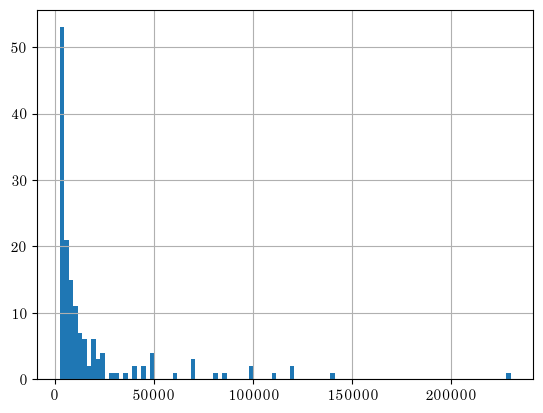

In [ ]:
picher['연봉(2018)'].hist(bins=100) # 2018년 연봉 분포 
# plt.hist()
# bins: 가로축 구간의 개수

<AxesSubplot: >

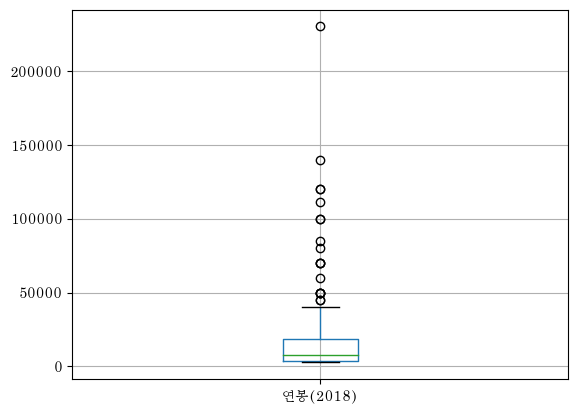

In [ ]:
picher.boxplot(column=['연봉(2018)']) # 2018년 연봉 범주
# plt.boxplot()

**상자 그림(Box Plot)**  
- 데이터의 사분위값 특성을 이용하여 데이터의 분포를 파악하는 그림 표현 방법  

히스토그램에서는 연봉의 분포를 파악할 수 있으며, 상자 그림에서는 연봉의 일반적인 범주를 파악할 수 있다.  
흔히 말하는 '수십억대 연봉'을 받는 프로 선수는 별로 많지 않으며, 5억 원 미만의 연봉이 일반적인 것으로 보인다.  

다음으로 각각의 피처들은 어떤 특성을 가지고 있는지 살펴보자.  

'선수명'이나 '팀명'과 같이 그래프로 표현할 수 없는 피처들은 제외한 뒤,  
모든 수치형 피처의 분포를 시각화해서 피처들의 분포를 확인할 수 있다.  

In [ ]:
picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

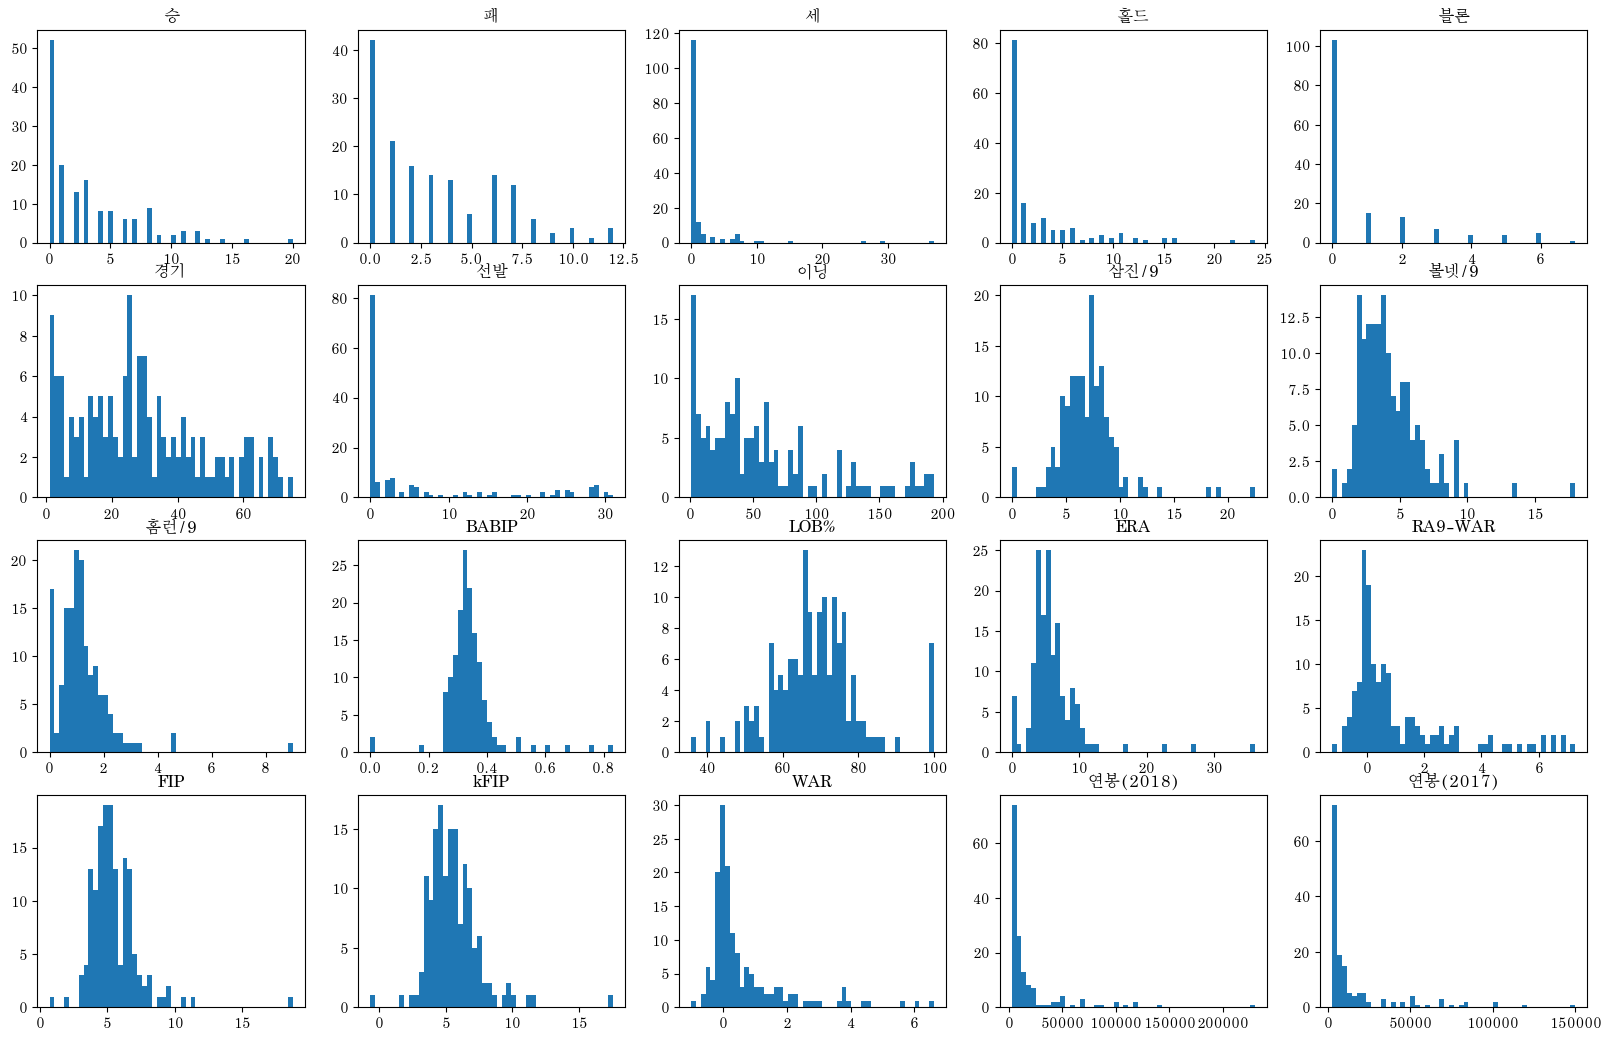

In [ ]:
## 회귀 분석에 사용할 피처 살펴보기 ##
picher_features_df = picher[['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', 
                             '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 
                             'kFIP', 'WAR','연봉(2018)', '연봉(2017)']]

# 피처 각각에 대한 히스토그램 출력
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1) # figure의 고유 식별자를 1로 지정?
    
    # df의 열 개수 만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1) # 5x5의 i+1번째 위치에 그래프 생성
        plt.hist(df[df.columns[i]], bins=50) # 50개의 구간으로 이루어진 히스토그램
        ax.set_title(df.columns[i]) # 컬럼명으로 제목 지정
    plt.show()

plot_hist_each_column(picher_features_df)

몇몇 피처들은 매우 불균형한 분포를 가지고 있다는 것을 알 수 있다.  

또 한 가지 그래프를 통해 알 수 있는 것은 각 피처 간의 단위가 다르다는 것이다. (x축의 값, 범위가 제각기 다름)  
이러한 데이터는 피처의 정규화 혹은 스케일링이 되어있지 않은 데이터이다.  

**피처의 정규화**  
- 좁은 의미로 피처 스케일링을 의미한다.  
- 피처 스케일링: 피처들의 단위를 0~1 사이, 혹은 상대적 값을 표현할 수 있는 수치로 맞춰주는 것  

## 1.2 예측: 투수의 연봉 예측하기

여러 가지 피처 스케일링 방법 중 **표준화** 방법을 적용해보자.  

표준화는 정규 분포에서의 z-값을 구하는 과정과 동일하다.  
z-값 = ((x)-(x의 평균) / X의 표준편차)

In [ ]:
## 피처들의 단위 맞추기: 피처 스케일링 for 수치형 ##
# 판다스 데이터를 출력할 때 scientific-notation이 아닌 float 모양으로 출력
pd.options.mode.chained_assignment = None # e^n 이런거 말고 전체 출력 해준다는 듯

# 피처 각각에 대한 스케일링을 수행하는 함수 정의
def standard_scaling(df, scale_columns):
    for col in scale_columns: 
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

# 피처 각각에 스케일링 수행
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', 
                 '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 
                 'kFIP', 'WAR', '연봉(2017)'] # 전체 컬럼 아니고 스케일링할 수치형 피처 모음
picher_df = standard_scaling(picher, scale_columns)

# 피처 '연봉(2018)' 을 'y'로 이름 변경 (타겟)
picher_df = picher_df.rename(columns={'연봉(2018)':'y'})

picher_df.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


연속형이 아닌 범주형 피처는 **원-핫 인코딩(One-Hot Encoding)**이라는 방법을 적용할 수 있다.  

원-핫 인코딩 예시) 과일 사과, 오렌지, 키위가 있다고 가정했을 때  

 사과: [1 0 0]  
오렌지: [0 1 0]  
 키위: [0 0 1]  
 
이렇게.. 벡터로 표현하는 방식.. 범주가 많아질수록 개수에 비례하게 늘어나는 데이터셋의 크기가 단점

판다스에서는 get_dummies()라는 함수로 간단하게 원 핫 인코딩을 적용할 수 있다.  

In [ ]:
## 피처들의 단위 맞추기: 원-핫 인코딩 for 범주형 ##
# 팀명 피처를 원-핫 인코딩으로 변환
team_encoding = pd.get_dummies(picher_df['팀명'])
picher_df = picher_df.drop('팀명', axis=1) # 기존 '팀명' 피처 삭제
picher_df = picher_df.join(team_encoding) # 인코딩한거 붙이기

team_encoding.head()

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [ ]:
picher_df.head()

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0


회귀 분석 모델을 학습시키기에 앞서, 학습 데이터셋과 테스트 데이터셋으로 데이터를 분리해야한다. 

In [ ]:
## 회귀 분석을 위한 학습, 테스트 데이터셋 분리 ##
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리
X = picher_df[picher_df.columns.difference(['선수명', 'y'])] # 인자에 있는 컬럼을 제외함
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
## 회귀 분석 계수 학습 & 학습된 계수 출력 ##
# 회귀 분석 계수 학습 (회귀 모델 학습)
from sklearn import linear_model

lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train) 

# 학습된 계수 출력
print(lr.coef_)

[ -1863.27167152   1147.15608757 -52147.32574794   5915.51391759
   2299.44885884  -1744.6150334     397.17996335   -249.60365919
  -1024.27838506    399.1396206   12274.79760529  44088.31585257
  -3602.91866901  -5319.02202278    617.34035282   4644.19380296
    879.30541662  -3936.74747195   1521.68382584 -10999.04385918
   -700.8303505    4526.7078132   21785.5776696    6965.59101874
    154.91380911   2018.54543747  -1217.59759673   9090.86143072]


## 1.3 평가: 예측 모델 평가하기

In [ ]:
## 어떤 피처가 가장 영향력이 강한 피처일까 ##
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석 수행
X_train = sm.add_constant(X_train) 
    # add_constant: 상수항 결합 (회귀분석모형 수식을 간단하게 만들기 위해 상수항을 독립변수 데이터에 추가하는 것)
model = sm.OLS(y_train, X_train).fit()
    # OLS(Ordinary Least Square): 잔차 제곱합을 최소화하는 가중치 벡터를 행렬 미분으로 구하는 방법
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     47.38
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           4.02e-43
Time:                        15:44:01   Log-Likelihood:                -1268.6
No. Observations:                 121   AIC:                             2593.
Df Residuals:                      93   BIC:                             2671.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.7e+04    834.138     20.376      0.000    1.53e+04    1.87e+04
BABIP      -1863.2717   1613.607     -1.155      0.251   -5067.575    1341.032
ERA         1147.1561   2783.168      0.412      0.681   -4379.664    6673.976
FIP        -5.215e+04   1.04e+05     -0.501      0.618   -2.59e+05    1.55e+05
KIA         7803.9703   3057.328      2.553      0.012    1732.722    1.39e+04
KT          4187.9052   2632.015      1.591      0.115   -1038.755    9414.566
LG           143.8413   2919.308      0.049      0.961   -5653.325    5941.008
LOB%         397.1800   1889.296      0.210      0.834   -3354.587    4148.947
NC          1638.8527   2979.707      0.550      0.584   -4278.254    7555.960
RA9-WAR    -1024.2784   3243.497     -0.316      0.753   -7465.220    5416.663
SK          2287.5960   2768.775      0.826      0.411   -3210.643    7785.835
WAR         1.227e+04   2849.066      4.308      0.000    6617.118    1.79e+04
kFIP        4.409e+04   8.88e+04      0.497      0.621   -1.32e+05     2.2e+05
경기         -3602.9187   3635.487     -0.991      0.324   -1.08e+04    3616.437
두산         -3430.5657   2757.660     -1.244      0.217   -8906.733    2045.601
롯데          2505.7967   3014.505      0.831      0.408   -3480.414    8492.007
볼넷/9        4644.1938   6679.685      0.695      0.489   -8620.336    1.79e+04
블론           879.3054   1506.355      0.584      0.561   -2112.017    3870.628
삼성         -2048.2911   2661.719     -0.770      0.444   -7333.938    3237.356
삼진/9        1521.6838   8494.807      0.179      0.858   -1.53e+04    1.84e+04
선발           -1.1e+04   6355.123     -1.731      0.087   -2.36e+04    1620.970
세           -700.8304   1766.608     -0.397      0.692   -4208.963    2807.302
승           4526.7078   2820.864      1.605      0.112   -1074.969    1.01e+04
연봉(2017)    2.179e+04   1354.925     16.079      0.000    1.91e+04    2.45e+04
이닝          6965.5910   7732.807      0.901      0.370   -8390.230    2.23e+04
패            154.9138   2184.662      0.071      0.944   -4183.391    4493.219
한화          3907.0018   2668.928      1.464      0.147   -1392.960    9206.964
홀드         -1217.5976   1746.941     -0.697      0.488   -4686.676    2251.481
홈런/9        9090.8614   1.79e+04      0.508      0.613   -2.65e+04    4.46e+04
==============================================================================
Omnibus:                       27.027   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.274
Skew:                          -0.097   Prob(JB):                     9.05e-54
Kurtosis:                       9.958   Cond. No.                     2.86e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

 **회귀 분석이 얼마나 잘 되었는지** 평가하는 지표: **결정 계수(R-squared)** 와 **수정 결정 계수(Adj. R-squared)**  
 '회귀 분석으로 추정한 모델이 주어진 데이터를 얼마나 잘 설명하는가?'에 대한 점수이다.  
 계수가 1에 가까울수록 데이터를 잘 설명하는 모델이라고 할 수 있다.  
 
 다음으로, **F 통계량(F-statistic)** 은 회귀식의 **유의성 검정**에 사용되는 값으로,  
 F 통계량에 대한 **p-value인 Prob(F-statistic)** 수치와 함께 살펴봐야 한다.  
 일반적으로 p-value가 **0.05 이하** 면 **'F 통계량이 유의한 의미를 가진다'** 는 결론을 내려도 무방하며  
 이는 회귀 분석이 유의미한 결과를 가진다는 것이다.  
 
 또한 **P>|t|** 는 **각 피처의 검정 통계량(t-statistics)이 얼마나 유의미한지에 대한 p-value**를 나타낸다.  
 
 위 분석에서는 'WAR', '연봉(2017)', '한화' 3개 피처의 p-value가 0.05 미만으로 나타났기 때문에 회귀 분석에서  
 유의미한 피처들이라는 결론을 내릴 수 있다. 

다음으로 지금까지 학습한 coef(회귀 계수) 값들을 시각화하여 살펴보자.  

In [ ]:
# 설치된 폰트 출력
# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

[Text(0, 0, 'const'),
 Text(1, 0, 'BABIP'),
 Text(2, 0, 'ERA'),
 Text(3, 0, 'FIP'),
 Text(4, 0, 'KIA'),
 Text(5, 0, 'KT'),
 Text(6, 0, 'LG'),
 Text(7, 0, 'LOB%'),
 Text(8, 0, 'NC'),
 Text(9, 0, 'RA9-WAR'),
 Text(10, 0, 'SK'),
 Text(11, 0, 'WAR'),
 Text(12, 0, 'kFIP'),
 Text(13, 0, '경기'),
 Text(14, 0, '두산'),
 Text(15, 0, '롯데'),
 Text(16, 0, '볼넷/9'),
 Text(17, 0, '블론'),
 Text(18, 0, '삼성'),
 Text(19, 0, '삼진/9'),
 Text(20, 0, '선발'),
 Text(21, 0, '세'),
 Text(22, 0, '승'),
 Text(23, 0, '연봉(2017)'),
 Text(24, 0, '이닝'),
 Text(25, 0, '패'),
 Text(26, 0, '한화'),
 Text(27, 0, '홀드'),
 Text(28, 0, '홈런/9')]

/Users/hyegwan/opt/anaconda3/envs/pybook/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/hyegwan/opt/anaconda3/envs/pybook/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


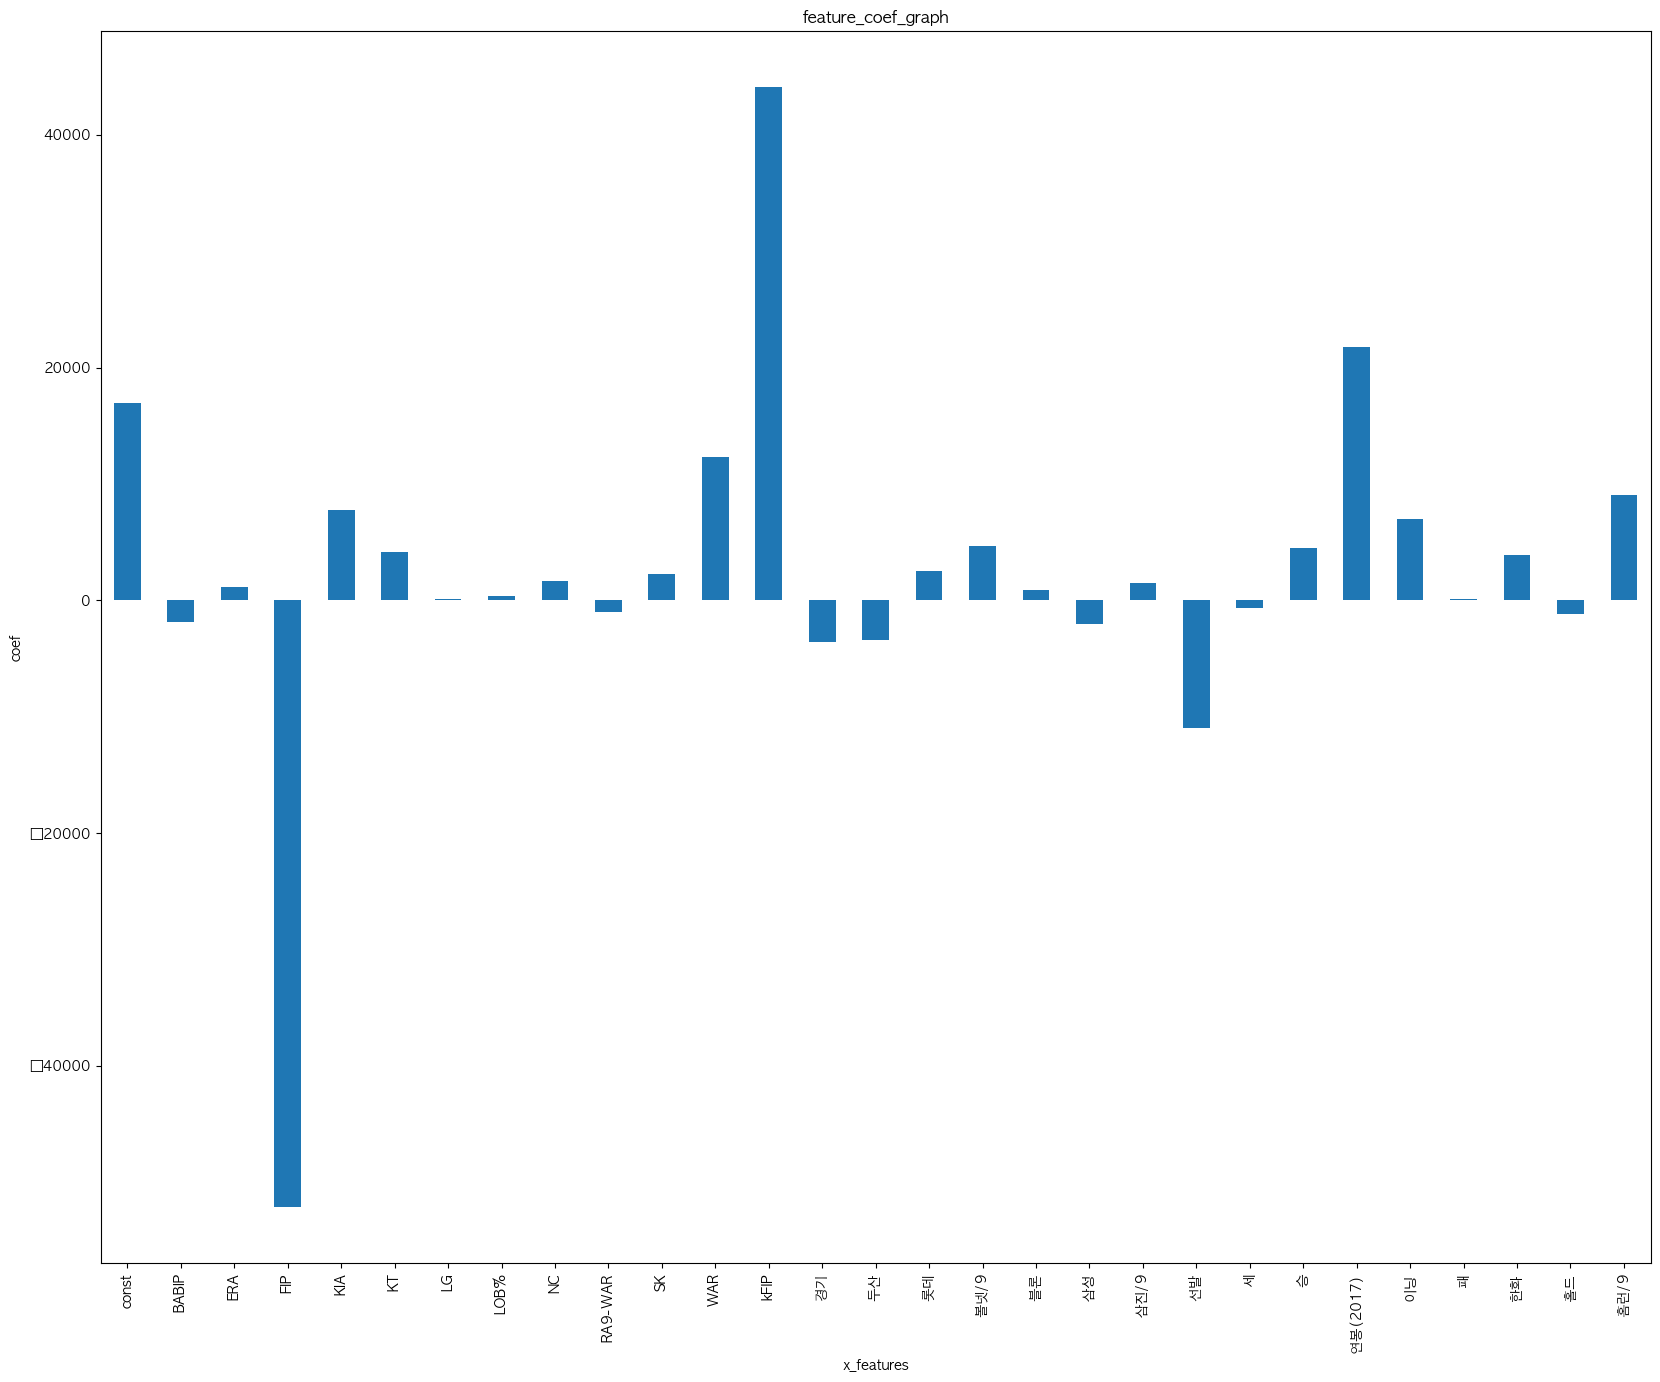

In [ ]:
## 어떤 피처가 가장 영향력이 강한 피처일까 ##
# 한글 출력을 위한 사전 설정
import matplotlib as mpl
mpl.rc('font', family='AppleGothic')
plt.rcParams['figure.figsize'] = [20, 16]

# 회귀 계수를 리스트, 시리즈로 반환
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명을 리스트로 반환
x_labels = model.params.index.tolist()

# 회귀 계수 출력
ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

시각화 결과, FIP, WAR, 연봉(2017),홈런 피처가 가장 영향력이 큰 것으로 보인다.  

현재까지의 피처 탐색결과는 다음과 같이 정리할 수 있다.   
유의미한 피처인가? - P>|t|
영향력이 큰 피처인가? - coef

'FIP'
- 유의미한 피처인가? X
- 영향력이 큰 피처인가? O  

'연봉(2017)'
- 유의미한 피처인가? O
- 영향력이 큰 피처인가? O 

다음으로 수정 결정 계수(R2 score)를 sklearn의 LinearRegression 클래스로 출력해보자.

**R2 score**

In [ ]:
## 예측 모델 평가하기: R2 score (수정 결정 계수) ##
# 학습 데이터와 테스트 데이터로 분리
X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   random_state=42)

# 회귀 분석 모델 학습
lr = linear_model.LinearRegression()
model=lr.fit(X_train, y_train)

# 회귀 분석 모델 평가
print(model.score(X_train, y_train)) # train R2 score 출력
print(model.score(X_test, y_test)) # test R2 score 출력

0.9322281224002374
0.7553039258172339


실행 결과의 각 값은 **학습 데이터셋과 테스트 데이터셋에 대한 평가 점수**를 의미한다.  
이 두 점수는 최대한 벌어지지 않는 것이 좋다.  
**만약 학습 점수가 테스트 점수에 비해 높다면 과적합이 발생한 것이다.**  
모의고사에만 특화된 공부를 한 나머지, 실제 시험의 새로운 유형에 적응하지 못하는 경우라고 비유할 수 있다.  

회귀 모델을 평가할 때는 **RMSE(Root Mean Square Error) score**라는 측정 지표를 활용할 수도 있다.  
이 점수는 **실제값과 예측값의 차이를 절대적인 수치로 나타낸 것**이다.  
이 값이 높으면 높을수록 예측이 부정확하다는 것을 의미한다. 

**RMSE score**

In [ ]:
## 예측 모델 평가하기: RMSE score ##
# 회귀 분석 모델 평가
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score 출력
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score 출력

8650.141349496093
9042.133575225975


이번에는 **피처들의 상관 관계**를 살펴보기 위해 heatmap 방식의 시각화를 사용해보자.  

**heatmap**

In [ ]:
## 피처들의 상관 관계 분석하기 ##
import seaborn as sns

# 피처 간의 상관계수 행렬을 계산합니다
corr = picher_df[scale_columns].corr(method='pearson') 
    # scale_columns: 위에서 만든 스케일 할 피처 모음 리스트

show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match',
            'start', 'inning', 'strike3', 'ball4', 'homerun', 'BABIP',
             'LOB', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', 'y', '2017']
    # label을 위한 피처명 리스트. 한글 -> 영어
    
# corr 행렬 히트맵 시각화
plt.rc('font', family='AppleGothic')
sns.set(font_scale=1.5)

hm = sns.heatmap(corr.values,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=show_cols,
                xticklabels=show_cols)

plt.tight_layout() # Adjust the padding between and around subplots.
plt.show()

이를 통해 승-이닝, kFIP_FIP, RA9_WAR-WAR 등의 피처 쌍에서 높은 연관성을 발견할 수 있다.  

하지만 **회귀 분석**은 **피처 간의 '독립성'을 전제로 하는 분석 방법**이기 때문에 올바른 회귀 분석을 하려면 이러한 **피처 쌍을 제거**해야 한다.   

그래서 **다중 공선성**이라는 것을 살펴봐야 한다.  
다중 공선성이란 **변수 간 상관 관계가 높아 분석에 부정적인 영향을 미치는 것**을 의미한다.  
다중 공선성을 살펴봄으로써 여러 피처 간의 연관성을 고려했을 때 어떤 피처를 제거하는 것이 옳은 판단일지  
혹은 제거하는 것 자체가 맞는 판단인지에 대한 기준을 제시해줄 수 있다.  

다중 공선성은 **분산팽창요인(Variance Inflation Factor, VIF)** 이라는 계수로 평가할 수 있다.  
일반적으로 **VIF 계수가 10~15 정도를 넘으면 그 피처는 다중 공선성의 문제가 발생한다고 판단**한다.  

**다중 공선성 확인**

In [ ]:
## 회귀 분석 예측 성능을 높이기 위한 방법: 다중 공선성 확인 ##
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    # X.values의 i번째 독립변수의 vif 계산
    # 반복문을 통해 데이터의 각 피처마다 vif 계산 함수 적용
    # X.shape[1]: 피처 수 28개 
vif['features'] = X.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


실행 결과, 많은 개수의 피처가 다중 공선성 문제를 가진 것을 알 수 있다. (10~15 이상)

이제 **적절한 피처를 선정하여 다시 학습**해보자.  

위의 예제로부터 알게 된 사실은 다음과 같다.  
- 회귀식에 큰 영향을 미치는 피처: 'WAR', '연봉(2017)', 'FIP', '볼넷/9', '삼진/9', '홈런/9' 
- 그 중에서 유의미한 피처: 'WAR', '연봉(2017)'  
- 또한 'FIP', 'kFIP'와 같이 강한 상호 연관성을 가진 피처들은 높은 VIF수치를 보인다.  

이러한 요소들을 고려하여 사용할 피처를 다시 선별한 뒤 회귀 분석을 수행해보자.  
이 때의 Train score, Test score가 어떻게 향상되는지, 새로운 피처들의 다중 공선성은 얼마나 되는지를 살펴보자.  

In [ ]:
# 피처 재선정
X = picher_df[['WAR', '연봉(2017)', 'FIP', '볼넷/9', '삼진/9']]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

In [ ]:
# 모델 학습
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [ ]:
# 결과 출력
print(model.score(X_train, y_train)) # trian R2 
print(model.score(X_test, y_test)) # test R2

0.9170639277736519
0.878204556119582


In [ ]:
 # 회귀 분석 모델 평가
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score

9569.079818445487
6379.298715124851


In [ ]:
# 피처마다의 VIF 계수 출력
X = picher_df[['WAR', '연봉(2017)', 'FIP', '볼넷/9', '삼진/9']]

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.round(1)

,VIF Factor,features
0,2.1,WAR
1,1.9,연봉(2017)
2,1.9,FIP
3,1.9,볼넷/9
4,1.1,삼진/9


test R2, test RMSE, vif factor 모두 이전 학습보다 향상된 결과를 보인다.  

## 1.4 시각화: 분석 결과 시각화하기

마지막 단계에서는 **회귀 분석을 통해 얻어낸 예측 연봉과 18년의 실제 연봉 데이터를 비교**하는 시각화 자료를 만들어 보자.  

아래는 회귀 분석 모델의 predict() 함수를 사용하여 18년 연봉을 예측하고, 이를 원래의 데이터 프레임에 '예측연봉'이라는 새로운 피처로 합친다.  

단, 데이터 프레임을 생성할 때 한 가지 추가된 조건은 '재계약하여 연봉이 변화한 선수만을 대상으로 한다'는 조건이다.  
재계약 하지 않은 선수는 연봉에 변화가 없으므로 예측의 의미가 없기 때문이다.

In [ ]:
## 예측연봉과 실제연봉 비교하기 ##
# 18년 연봉을 예측하여 데이터 프레임의 열로 생성
X = picher_df[['WAR', '연봉(2017)', 'FIP', '볼넷/9', '삼진/9']] # picher_df: 스케일링 된 df
predict_18_salary = lr.predict(X)  # 위에서 학습이 되어 있는 lr
picher_df['예측연봉(2018)'] = pd.Series(predict_18_salary)

In [ ]:
picher_df.columns

Index(['선수명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9',
       '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', 'y',
       '연봉(2017)', 'KIA', 'KT', 'LG', 'NC', 'SK', '두산', '롯데', '삼성', '한화',
       '예측연봉(2018)'],
      dtype='object')

In [ ]:
# 원래 데이터 프레임 다시 불러오기
picher = pd.read_csv(picher_file_path)
picher = picher[['선수명', '연봉(2017)']]

# 원래 데이터 프레임에 2018 연봉 합치기
result_df = picher_df.sort_values(by=['y'], ascending=False) # 'y'기준 내림차순 정렬
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore') # '연봉(2017)' 드랍
result_df = result_df.merge(picher, on=['선수명'], how='left') # '선수명'을 기준으로 df 합치기
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']] # 필요한 피처만 추출
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)'] 
    # rename 'y' to '실제연봉(2018)' & '연봉(2017)' to '작년연봉(2017)'

# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df


,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,178640.388259,150000
1,1,켈리,140000,127613.689573,85000
2,2,소사,120000,92288.866803,50000
3,4,레일리,111000,109812.519156,85000
4,7,피어밴드,85000,61114.831577,35000
5,13,배영수,50000,61215.398968,55000
6,21,안영명,35000,23237.834847,20000
7,22,채병용,30000,21467.616557,25000
8,23,류제국,29000,47316.605493,35000
9,24,박정진,25000,29902.453234,33000


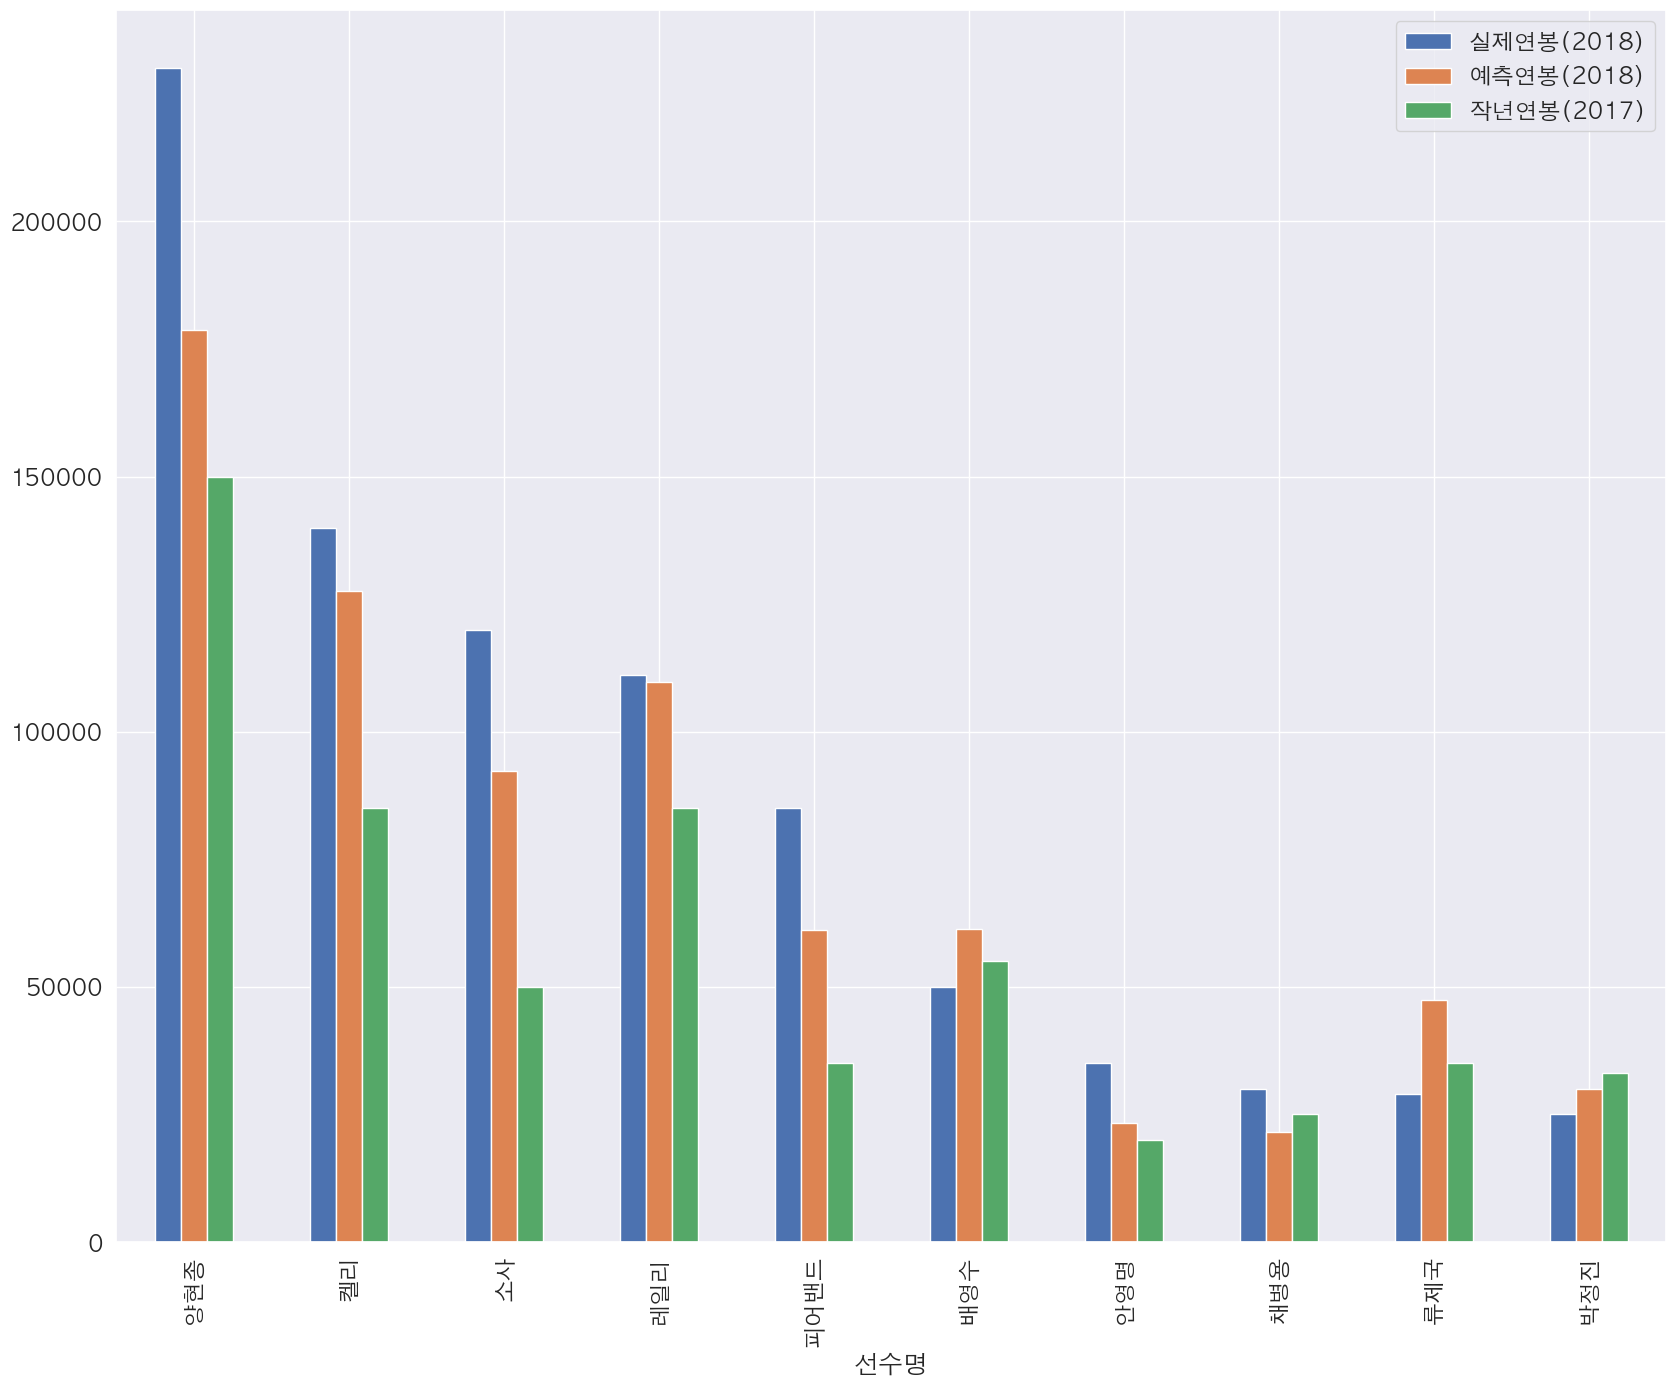

In [ ]:
# 선수별 연봉 정보를 막대 그래프로 출력
mpl.rc('font', family='AppleGothic')
result_df.plot(x='선수명', y=['실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)'], kind='bar')
plt.show()

## 정리

- **데이터의 분리**
    - 학습 데이터셋과 테스트 데이터셋 분리  
      : 회귀 분석 모델을 학습 데이터셋으로 학습하고 이를 테스트 데이터셋으로 평가한다 (지도학습).
- **피처 정규화**  
    - 데이터의 피처 스케일링
      : 피처 간의 단위를 맞춰주는 피처 스케일링 작업 수행한다.  
- **범주형 피처의 변환**
    - 원-핫 인코딩
      : 연산 불가능한 범주형 피처를 연산 가능한 벡터 형태의 피처로 변환한다.  
- **회귀 분석 평가**  
    - R2 score, RMSE score
      : R2, RMSE 등의 평가 지표를 통해 회귀 분석이 얼마나 잘 되었는지 평가한다.  
- **다중 공선성 분석**
    - 피처 간의 독립성 검정
      : VIF 계수를 통해 피처 간의 다중 공선성 문제를 검증한다.  

# 2. 비트코인 시세 예측하기   

비트코인 시세처럼 **연속적인 시간에 따라 다르게 측정되는 데이터**를 **시계열 데이터**라 한다.  
시계열 데이터 분석은 심장 박통 데이터처럼 **규칙적** 시계열 데이터를 분석하는 것과  
비트코인 시세 예측처럼 **불규칙적** 시계열 데이터를 분석하는 것으로 구분할 수 있다.  

## 2.1 탐색: 시간 정보가 포함된 데이터 살펴보기

In [21]:
## market price 데이터셋의 기본 정보 구하기 ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 출처: https://www.blockchain.com/explorer/charts/market-price?timespan=60days
file_path = 'Desktop/python-data-analysis-master/data/market-price.csv'
file_path1 = '/content/market-price.csv'

bitcoin_df = pd.read_csv(file_path1, names=['day', 'price'])

# 기본 정보 출력
print(bitcoin_df.shape)
print(bitcoin_df.info())
bitcoin_df.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


실행 결과, 비트코인 데이터는 총 365개의 행으로 이루어져 있으며,  
데이터는 결측값 없이 날짜와 가격에 대한 2개의 피처로 구성되어 있다 (시계열 데이터).  

시계열 정보를 데이터 프레임의 인덱스로 설정하여 가격의 추이를 시각화 해보자.  

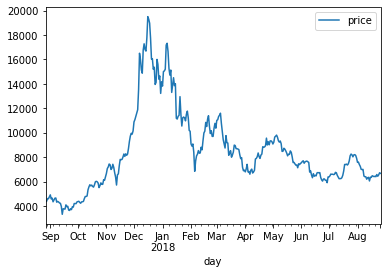

In [22]:
# to_datetime으로 day 피처를 시계열 피처로 변환 (현재 day 피처의 데이터 타입은 objcet이다.)
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 피처를 데이터 프레임의 인덱스로 설정
# bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

# 일자별 비트코인 시세 시각화
bitcoin_df.plot()
plt.show()

## 2.2 예측: 파이썬 라이브러리를 활용해 시세 예측하기

이번 예제에서 사용할 시계열 예측 분석 방법은 **ARIMA** 분석 방법이다.  

ARIMA는 전통적인 시계열 예측 방법으로 크게 두 가지 개념을 포함하고 있다.  
1. AR(Autoregression) 모델. 자기 자신의 과거를 정보로 사용하는 개념  
    - 이는 '현재의 상태는 이전의 상태를 참고해서 계산된다'는 아이디어를 전제로 한다.  
2. MA(Moving Average) 모델.  
    - 이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하는 방법  

이 둘을 합친 것을 **ARMA** 모델이라고 하며, 조금 더 나아간 **ARIMA** 모델은 **ARMA 모델에 추세 변동의 경향성(Momentum)까지 반영한 방법**이다.  

파이썬에서는 statsmodel 모듈로 ARIMA 분석을 수행할 수 있다.

**ARIMA 분석**

In [25]:
## ARIMA 모델 활용하기: 모델 학습 ##
from statsmodels.tsa.arima.model import ARIMA
import  statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습
# AR: AR이 몇 번째 과거까지를 바라보는지에 대한 파라미터
# 차분(Difference): 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것. 차분하는 횟수에 대한 파라미터. 
#                  시계열 데이터의 불규칙성을 조금이나마 보정해준다. 또한 ARIMA 모델의 경향성을 의미한다. 
# MA: MA가 몇번째 과거까지를 바라보는지에 대한 파라미터
model = ARIMA(bitcoin_df['price'].values, order=(2,1,2), trend='t',
              enforce_stationarity=False, 
              enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2768.343
Date:                Thu, 16 Feb 2023   AIC                           5548.687
Time:                        06:55:13   BIC                           5572.020
Sample:                             0   HQIC                          5557.963
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.3708     31.857      0.200      0.841     -56.068      68.809
ar.L1         -1.4690      0.272     -5.403      0.000      -2.002      -0.936
ar.L2         -0.4861      0.260     -1.873      0.0

실행 결과에서 계수의 p-value가 0.05 이하면 유의미하다고 판단한다.  
계수들의 p-value를 확인하여 AR과 MA의 파라미터를 판단할 수 있다.  

**ARIMA 분석의 파라미터**  
예제와 별개로 order 파라미터 (p, d, q)는 일반적인 가이드라인이 존재한다.  
보통은 p와 q의 합이 2 미만인 경우, 혹은 p와 q의 곱이 을 포함한 짝수인 경우가 좋은 파라미터의 조합이라고 알려져있다.  

In [ ]:
# 폰트 설정
import matplotlib as mpl
mpl.rc('font', family='Arial')

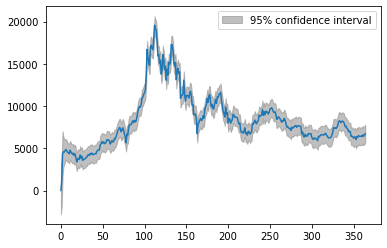

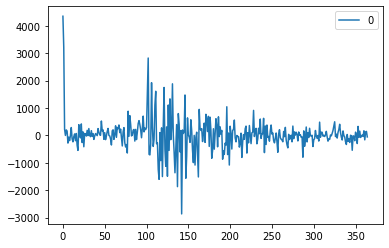

In [26]:
## ARIMA 모델 활용하기: 모델의 성능 & 예측 결과 시각화 ##
from statsmodels.graphics.tsaplots import plot_predict

# 학습 데이터에 대한 예측 결과 (첫 번째 그래프)
plot_predict(model_fit)

# 잔차의 변동을 시각화 (두 번째 그래프)
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()

잔차 변동을 나타내는 두 번째 그래프의 폭이 일정하다면 좋은 예측 모델을 학습시킨 것이라고 할 수 있다.  
하지만 실행 결과에서는 오차 변동이 매우 불안정한 것으로 보인다.  

다음으로 **ARIMA 모델을 평가**해보자.  

모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데 이번 예제에서는 5일 동안의 미래를 테스트 데이터로 사용한다.  

불규칙적 시계열 예측의 경우에는 먼 미래를 예측하는 것이 큰 의미가 없으므로  
'앞으로 N일 동안 어느정도로 상승/하락할 것이다' 정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문이다.  

In [27]:
## ARIMA 모델 활용하기: 실제 데이터와의 비교 ##
# 학습 데이터셋으로부터 5일 뒤를 예측
forecast_data = model_fit.forecast(steps=5) 

# 마지막 5일의 예측 데이터
# pred_y = forecast_data[0].tolist()
pred_y = forecast_data.tolist() 

# 테스트 데이터셋 불러오기
test_file_path = 'Desktop/python-data-analysis-master/data/market-price-test.csv'
test_file_path2 = '/content/market-price-test.csv'

bitcoin_test_df = pd.read_csv(test_file_path2, names=['ds', 'y'])

# 마지막 5일의 실제 데이터
test_y = bitcoin_test_df['y'].values

# 예측 데이터의 최소값, 최대값 정의
# pred_y_lower = [] # 최소값
# pred_y_upper = [] # 최대값

# for lower_upper in forecast_data[2]:
#     lower = lower_upper[0]
#     upper = lower_upper[1]
#     pred_y_lower.append(lower)
#     pred_y_upper.append(upper)
pred_y_lower = forecast_data[0].tolist()
pred_y_upper = forecast_data[1].tolist()

In [ ]:
forecast_data

array([6673.36953996, 6683.10819958, 6687.58240229, 6695.10193426,
       6700.70723934])

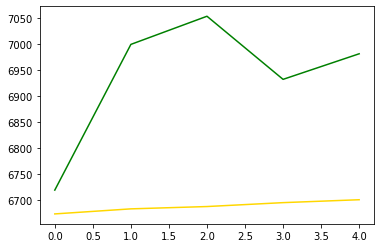

In [28]:
plt.plot(pred_y, color='gold') # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color='red') # 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_upper, color='blue') # 모델이 예측한 최고 가격 그래프
plt.plot(test_y, color='green') # 실제 가격 그래프

plt.show()

그래프를 살펴보면 그다지 좋지 않은 예측을 한 것으로 보인다.  
하지만 '5일 동안 상승할 것이다'라는 아주 큰 트렌드 정도는 예측할 수 있다.  

In [31]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print('ARIMA RMSE: ', rmse)

ARIMA RMSE:  272.9641221093833


이번에는 ARIMA보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 **'Facebook Prophet'** 을 사용해보자.  

Prophet은 **Addictive 모델**이라는 모델링 방법에 기반한 시계열 예측 모델로서  
**시계열 데이터의 트렌드성(연간/월간/일간)을 예측**하는 것에 초점이 맞추어져 있다.

**Addictive 모델**  
선형 회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나이다.  
시계열 분석 역시 회귀 분석의 한 갈래이기 때문에 회귀 분석의 단점을 가지고 있다.  
회귀 분석의 단점을 극복하기 위해 이 모델은 각 피처마다 비선형적 적합을 가능하게 하는 일련의 방법을 적용한다.  

**Facebook Prophet**

In [33]:
## Facebook Prophet 활용하기 ##
import pandas as pd
from prophet import Prophet

# prophet을 사용하기 위한 피처명 변경
file_path2 = '/content/market-price.csv'
bitcoin_df = pd.read_csv(file_path2, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5) # 트렌드가 변경되는 문맥을 반영한다. 수치가 높을수록 과적합에 가까워진다.
prophet.fit(bitcoin_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zlt_dyo/_chl4x_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zlt_dyo/xkc18ag5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87896', 'data', 'file=/tmp/tmp2zlt_dyo/_chl4x_p.json', 'init=/tmp/tmp2zlt_dyo/xkc18ag5.json', 'output', 'file=/tmp/tmp2zlt_dyo/prophet_modelze159c4r/prophet_model-20230216065830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
# 5일 단위의 미래 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5) # yhat: 예측값

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6890.872715,6250.608465,7556.427387
366,2018-08-28,6985.959783,6364.386537,7624.426407
367,2018-08-29,7001.119063,6264.900320,7694.075522
368,2018-08-30,7071.717475,6407.263152,7813.977523
369,2018-08-31,7149.818213,6360.010669,7901.280778


다음은 prophet 모델의 학습 결과를 시각화해보자.  

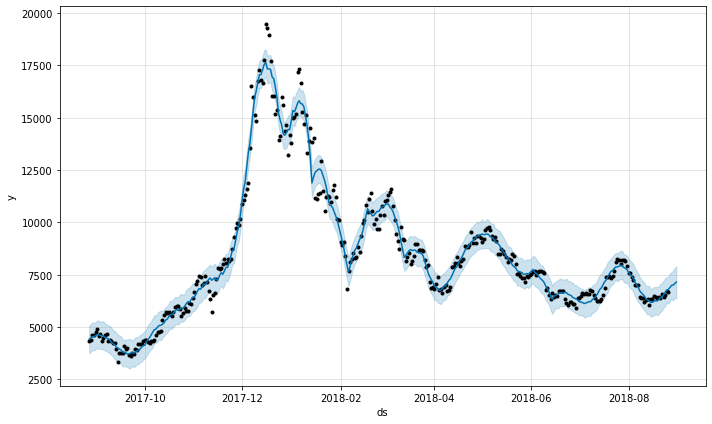

In [35]:
fig1 = prophet.plot(forecast_data)

그래프의 검은 점은 실제 가격을 나타낸 것이고, 파란 선은 예측 가격을 나타낸 것이다.

이 모델 역시 ARIMA 모델과 마찬가지로 학습 데이터셋에 대해서는 거의 정확한 예측을 하고 있다.  
하지만 시계열 데이터 분석에서 학습 데이터를 잘 예측하는 것은 큰 의미가 없다고 할 수 있다.  

다음 그래프는 prophet에서 제공하는 트렌드 정보 시각화 그래프이다.  
앞서 seasonality_mode 파라미터를 설정해놓은 경우에만 이 시각화가 가능하다.  
우리는 이를 통해 시계열 데이터가 어떤 흐름을 가지고 변화하는지를 살펴볼 수 있다.  

전체적인 데이터의 트렌드부터 year, weekly, daily 순의 트렌드를 확인해보자.  


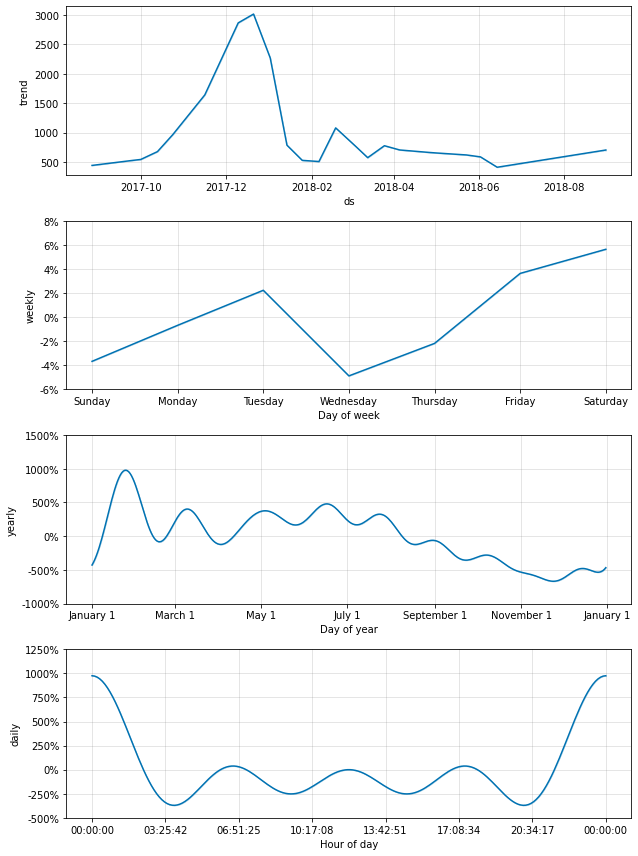

In [36]:
fig2 = prophet.plot_components(forecast_data)

ARIMA 모델을 평가한 것과 동일한 방법으로 테스트 데이터셋을 평가해보자.  

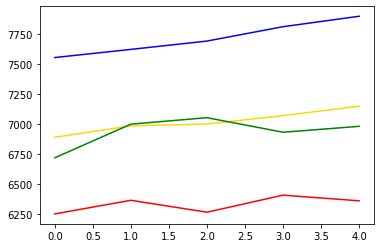

In [37]:
## Facebook Prophet 활용하기: 실제 데이터와의 비교 ##
import matplotlib.pyplot as plt

test_file_path2 = '/content/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path2, names=['ds', 'y'])

# 마지막 5일 예측 데이터 (2018-08-27 ~ 2018-08-31)
pred_y = forecast_data['yhat'].values[-5:]

# 실제 5일 가격 데이터 (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df['y'].values

# 마지막 5일 예측 데이터의 최소값
pred_y_lower = forecast_data['yhat_lower'].values[-5:]

# 마지막 5일 예측 데이터의 최대값
pred_y_upper = forecast_data.yhat_upper.values[-5:]

# 모델이 예상한 가격 그래프
plt.plot(pred_y, color='gold')

# 모델이 예상한 최저 가격 그래프
plt.plot(pred_y_lower, color='red')

# 모델이 예상한 최고 가격 그래프
plt.plot(pred_y_upper, color='blue')

# 실제 가격 그래프
plt.plot(test_y, color='green')

plt.show()

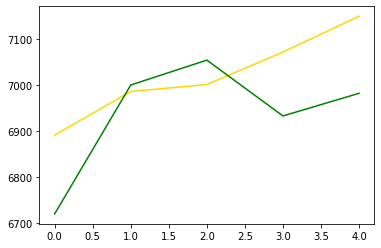

In [38]:
# 모델이 예상한 가격 그래프
plt.plot(pred_y, color='gold')

# 실제 가격 그래프
plt.plot(test_y, color='green')

plt.show()

위 그래프에서 노란 선(모델 예상)과 초록 선(실제 값)을 보면,  
ARIMA 모델보다는 prophet 모델이 실제 price값에 더 근접한 예측을 하는 것처럼 보인다.  

이를 RMSE와 함께 더 자세히 살펴보자.  

In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse2 = sqrt(mean_squared_error(pred_y, test_y))

print('ARIMA RMSE: ', rmse)
print('Prophet RMSE: ', rmse2)

ARIMA RMSE:  272.9641221093833
Prophet RMSE:  126.48326696424184


ARIMA 모델의 Test RMSE는 272 정도였던 것에 반해  
prophet 모델의 Test RMSE는 126 정도로 감소하였다.  

또한 '5일 동안 얼마만큼 상승할 것이다'라는 트렌드를 보다 정확하게 예측한 것으로 보인다.  

## 2.3 활용: 더 나은 결과를 위한 방법

이번 단계에서는 모델의 성능을 조금 더 향상시킬 수 있는 방법들에 대해 알아보자.  

첫 번째로 고려해볼 방법은 **상한값/하한값을 지정**해 주는 것이다.  
바닥과 천장이 없는 주가 데이터의 경우에는 의미가 없을 수 있지만 일반적인 시계열 데이터에서는  
상한값 혹은 하한값을 설정해 주는 것이 모델의 성능을 높여줄 수 있는 방법 중 하나이다.   

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zlt_dyo/89ic298t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zlt_dyo/txb_hfpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59593', 'data', 'file=/tmp/tmp2zlt_dyo/89ic298t.json', 'init=/tmp/tmp2zlt_dyo/txb_hfpn.json', 'output', 'file=/tmp/tmp2zlt_dyo/prophet_modelk6ln14wb/prophet_model-20230216070843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:08:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


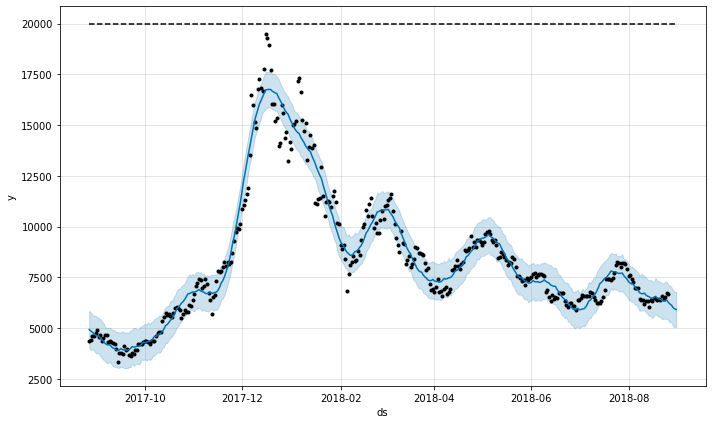

In [40]:
## 상한가 및 하한가 설정하기 ##
bitcoin_df = pd.read_csv(file_path2, names=['ds', 'y'])

# 상한가 설정
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터 설정
prophet = Prophet(seasonality_mode='multiplicative',
                  growth='logistic', #
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가 설정
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)
plt.show()

위 실행 결과는 **상한선을 적용한 학습 결과를 시각화** 한 것이다.  
겉으로 보기에는 원래의 결과와 별 차이가 없어 보인다.  

이번에는 **예측값과 실제값을 비교**해보자.  

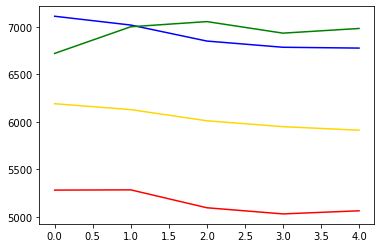

In [42]:
## 예측과 실제 비교 그래프 ##
bitcoin_test_df = pd.read_csv(test_file_path2, names=['ds', 'y'])

# 모델이 예측한 마지막 5일의 가격 데이터
pred_y = forecast_data['yhat'].values[-5:]
test_y = bitcoin_test_df['y'].values
pred_y_lower = forecast_data['yhat_lower'].values[-5:]
pred_y_upper = forecast_data['yhat_upper'].values[-5:]

plt.plot(pred_y, color='gold') # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color='red') # 모델이 예측한 하한가 그래프
plt.plot(pred_y_upper, color='blue') # 모델이 예측한 상한가 그래프
plt.plot(test_y, color='green') # 실제 가격 그래프

plt.show()

모델이 예측한 상한가(파란색)보다 실제 가격(초록색)이 더 높은 결과를 통해 예측 모델이 형편없는 결과를 예측했다는 것을 알 수 있다.  
게다가 이번에는 '5일 동안 상승/하락할 것이다'라는 큰 범위의 트렌드를 예측하는 것 조차 실패했다.  
상한가라는 개념이 큰 의미가 없는 비트코인 데이터의 경우에는 상한선을 설정한 것이 오히려 독이 되었다고 볼 수 있다.  

이제 모델의 성능을 향상시키는 두 번째 방법으로 **이상치를 제거**를 해보자. 

prophet 모델이 이상치를 제거한 데이터로 학습하려면  
이상치에 해당하는 데이터를 None으로 설정해주면 된다.  

아래에서는 18,000 이상을 이상치라고 설정하였다.  
그리고 나머지 부분은 이전과 동일하게 실행한다.  

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zlt_dyo/r_ymoy0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zlt_dyo/2yuc0e6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45562', 'data', 'file=/tmp/tmp2zlt_dyo/r_ymoy0j.json', 'init=/tmp/tmp2zlt_dyo/2yuc0e6a.json', 'output', 'file=/tmp/tmp2zlt_dyo/prophet_modeli084wjeu/prophet_model-20230216072232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:22:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


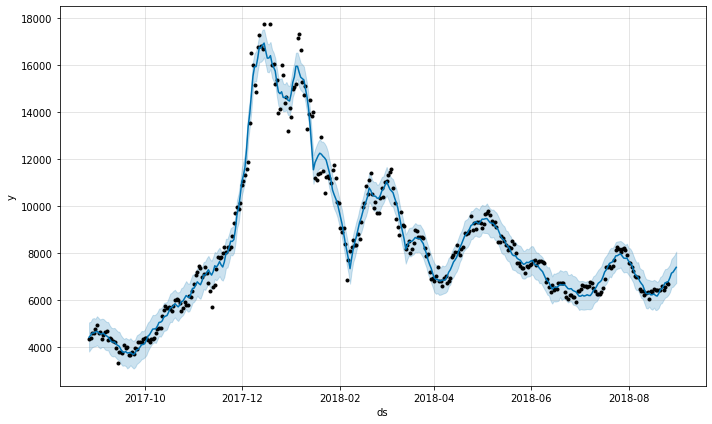

In [44]:
## 이상치 제거하기 ##
# 18,000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path2, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

# prophet 모델 학습
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일 단위의 미래 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력
fig = prophet.plot(forecast_data)

그래프만 놓고 본다면 이전과 큰 차이가 없어 보인다.  

동일한 방법으로 **예측값과 실제값**을 그래프로 나타내보자.  

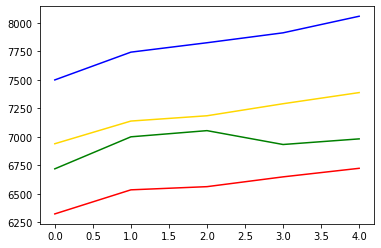

In [45]:
# 모델이 예측한 마지막 5일의 가격 데이터
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color='gold') # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color='red') # 모델이 예측한 하한가 그래프
plt.plot(pred_y_upper, color='blue') # 모델이 예측한 상한가 그래프
plt.plot(test_y, color='green') # 실제 가격 그래프

plt.show()

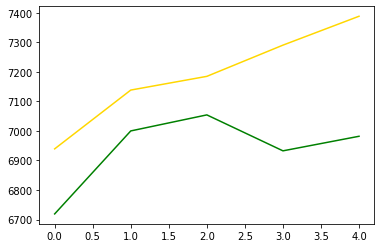

In [46]:
plt.plot(pred_y, color='gold') # 모델이 예측한 가격 그래프
plt.plot(test_y, color='green') # 실제 가격 그래프

plt.show()

In [48]:
# 테스트 데이터의 RMSE 평가
rmse3 = sqrt(mean_squared_error(pred_y, test_y))
print('ARIMA RMSE: ', rmse)
print('Prophet RMSE: ', rmse2)
print('Prophet_remve_outlier RMSE: ', rmse3)

ARIMA RMSE:  272.9641221093833
Prophet RMSE:  126.48326696424184
Prophet_remve_outlier RMSE:  274.7049104501476


실행 결과, 이상치를 제거하는 것이 정확도(RMSE)면에서는 떨어지지만 '트렌드'를 예측하는 측면에서는 이전 모델보다 더 낫다고 볼 수 있다.  

## 정리

- **시계열 데이터 분석**
    - 정의: 연도, 월, 일자 같은 시간성을 띠는 데이터를 학습하여 미래의 수치를 예측하는 분석
- **ARIMA 모델링**
    - 시계열 예측 분석 방법
      : ARIMA 모델은 '얼마만큼의 나를 돌아보며', '얼마만큼의 차분을 이용하여 규칙성을 줄 것이며', 얼마만큼의 오차를 관잘할 것인지'를 활용한 시계열 예측 분석의 방법이다.  
- **모델 평가**
    - 학습 데이터셋과 테스트 데이터셋의 분리
      : 특정한 시간 혹은 일자를 기준으로 학습 데이터셋과 테스트 데이터셋을 분리한다.  
- **모델 개선 방법**
    - 더 나은 분석을 위해 상한선과 하한선 설정, 이상치 제거 방법을 사용할 수 있다.  

# 3. 미래에 볼 영화의 평점 예측하기  

영화의 평점을 예측하여 아직 사람들이 보지 않았지만 좋아할 만한 영화들을 추천해보자.  

## 3.1 탐색: MovieLens 데이터 살펴보기

MovieLens 데이터는 총 3개의 데이터셋(rating, movie, user)으로 구성되어 있다.

In [1]:
## MovieLens 데이터셋의 기본 정보 구하기 ##
import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Source: https://grouplens.org/datasets/movielens

rating_file_path = 'Desktop/python-data-analysis-master/data/ml-1m/ratings.dat'
movie_file_path = 'Desktop/python-data-analysis-master/data/ml-1m/movies.dat'
user_file_path = 'Desktop/python-data-analysis-master/data/ml-1m/users.dat'

rating_data = pd.io.parsers.read_csv(rating_file_path,
                                    names=['user_id', 'movie_id', 'rating', 'time'],
                                    delimiter='::', encoding='ISO-8859-1', engine='python')
movie_data = pd.io.parsers.read_csv(movie_file_path,
                                    names=['movie_id', 'title', 'genre'],
                                    delimiter='::', encoding='ISO-8859-1', engine='python')
user_data = pd.io.parsers.read_csv(user_file_path,
                                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'],
                                    delimiter='::', encoding='ISO-8859-1', engine='python')

print('ratings')
print(rating_data.head())
print()
print('movies')
print(movie_data.head())
print()
print('users')
print(user_data.head())

ratings
   user_id  movie_id  rating       time
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

movies
   movie_id                               title                         genre
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

users
   user_id gender  age  occupation zipcode
0        1      F    1          10   48067
1        2      M   56          16   70072
2        3      M   25          15   55117
3        4      M   45           7   02460
4        5      M   25          20   55455


## 3.2 분석: 탐색적 데이터 분석하기

**영화 개수 탐색**

전체 영화 개수와 연도별 영화 개수를 알아보자.  

In [47]:
## 분석할 영화의 정보 탐색하기 ##
# 총 영화 개수
print('total number of movies in data: ', movie_data['movie_id'].nunique())

# 연도별 영화 개수가 많은 Top 10 연도 
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1]) # movie_data에 year 피처 생성
print('\nTOP 10 number of movies by year: ')
print(movie_data['year'].value_counts().head(10))

total number of movies in data:  3883

TOP 10 number of movies by year: 
1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64


영화의 개수는 약 4,000여 개 정도라는것을 알 수 있고, 1990년대 후반부터 2000년대 초반의 영화가 가장 많은 것을 알 수 있다.  

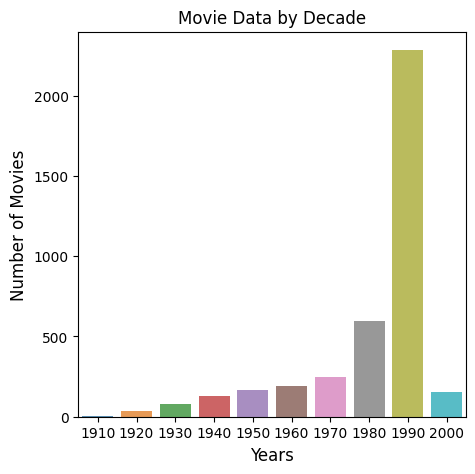

In [97]:
# 연대별 영화 개수 시각화
movie_data['years'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0") # movie_data에 year_term 피처 생성
movie_year_term = movie_data['years'].value_counts().sort_index() # 연대별 영화 개수

plt.figure(figsize=(5,5))
sns.barplot(x=movie_year_term.index, y=movie_year_term.values, alpha=0.8)
plt.title('Movie Data by Decade')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

**영화 장르 탐색**

다음으로 가장 많이 등장한 장르를 알아보자.  
movie_data의 genre 피처에는 '|' 구분자를 포함하여 여러 장르를 하나의 문자열에 포함하고 있다. ('Comedy|Romance')  
따라서 장르를 분리하고 장르마다 등장 개수는 딕셔너리 자료로 저장해보자.  

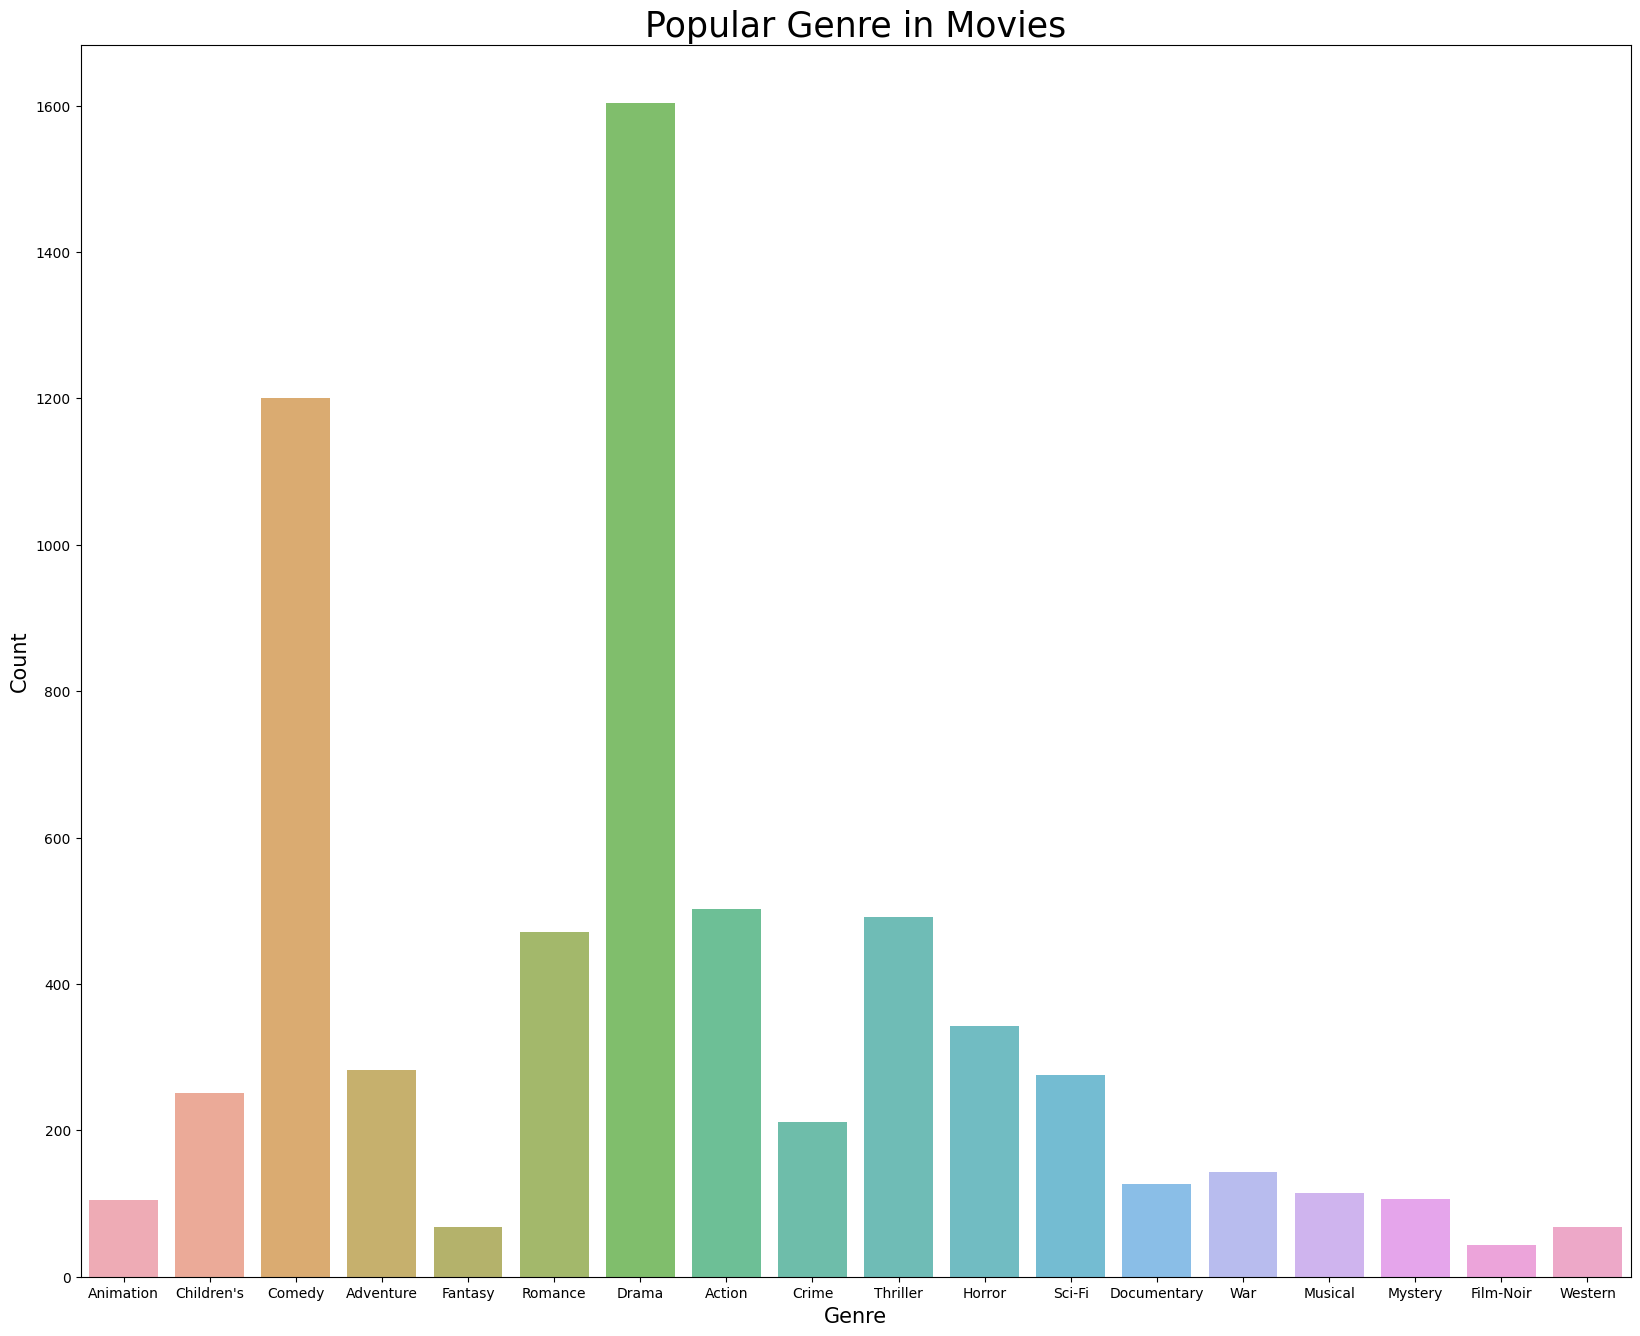

In [112]:
## 장르 속성 탐색하기 ##
# 가장 많이 등장한 장르 추출
genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 '|' 구분자로 분리
    genre_combination = row['genre']
    parsed_genre = genre_combination.split('|')
    
    # 분리한 장르를 genre_dict{}에 각각 계산하여 저장
    for genre in parsed_genre:
        if genre in genre_dict:
            genre_dict[genre] += 1 # 장르 딕셔너리에 있다면 1 더하기
        else:
            genre_dict[genre] = 1 # 장르 딕셔너리에 없다면 추가

# 장르별 영화 개수 시각화
plt.figure(figsize=(20, 16))
sns.barplot(x=list(genre_dict.keys()), y=list(genre_dict.values()), alpha=0.8)
plt.title('Popular Genre in Movies', fontsize=25)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Genre', fontsize=15)
plt.show()

드라마, 코미디, 액션 순서로 인기가 많은 것을 알 수 있다.

**유저 탐색**

In [86]:
# 유저의 수
print('total number of user in data: ', user_data['user_id'].nunique())

total number of user in data:  6040


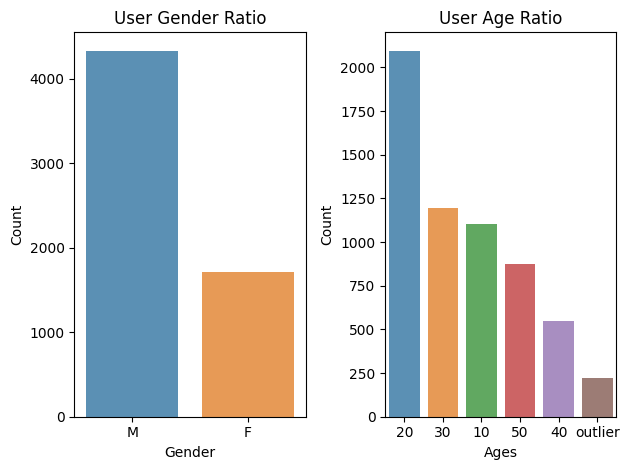

In [109]:
# 유저의 성별
user_gender = user_data['gender'].value_counts()

plt.subplot(1,2,1)
sns.barplot(x=user_gender.index, y=user_gender.values, alpha=0.8)
plt.title('User Gender Ratio')
plt.ylabel('Count', fontsize=10)
plt.xlabel('Gender', fontsize=10)

# 유저의 연령대
def age_classification(age):
    if age < 10 or age > 100:
        return 'outlier'
    else: 
        return str(age)[0]+'0' 

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x)) # 나이대 피처 생성
user_ages = user_data['ages'].value_counts() # 나이대별 유저 수 

plt.subplot(1,2,2)
sns.barplot(x=user_ages.index, y=user_ages.values, alpha=0.8)
plt.title('User Age Ratio')
plt.ylabel('Count', fontsize=10)
plt.xlabel('Ages', fontsize=10)

plt.tight_layout()
plt.show()

여성의 비율이 남성보다 약 2배 정도 높으며, 2-30대가 주 연령층이라는 것을 알 수 있다.  

**영화 평점 탐색**

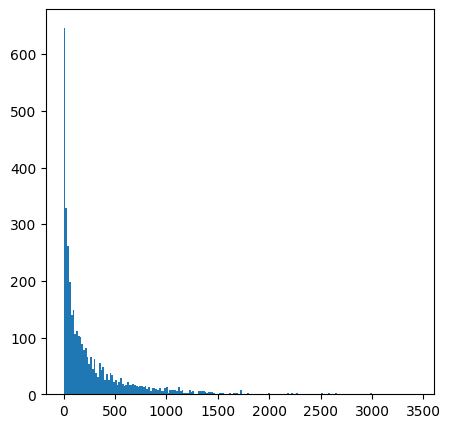

In [156]:
# 각 영화가 평가받은 횟수
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values

plt.figure(figsize=(5, 5))
plt.hist(movie_rate_count, bins=200)
plt.title = ('Rating Counts for Movies')
plt.ylabel = ('Count')
plt.xlabel = ("Movie's Rated Count")

plt.show()

x축은 평가 받은 횟수를 의미하고 y축은 평가 횟수의 빈도(= 평가 받은 횟수가 같은 영화의 수)를 의미한다.  

In [159]:
print ('total number of movie in data: ', movie_data['movie_id'].nunique())
print('total number of movie rated below 100:', len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data:  3883
total number of movie rated below 100: 1687


<AxesSubplot: >

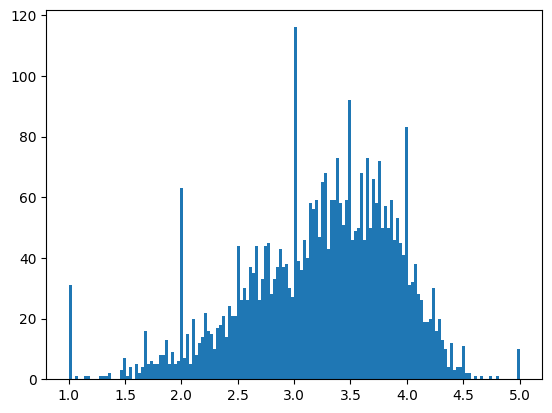

In [162]:
# 영화별 평균 평점
movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].agg(['count', 'mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

# 영화별 평균 평점 분포
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

plt.show()

위 시각화 결과를 통해 대부분의 영화 평점은 2점~4점 사이의 값으로 예측될 것이라는 가설을 수립할 수 있다.

**유저별 영화 평가 탐색**

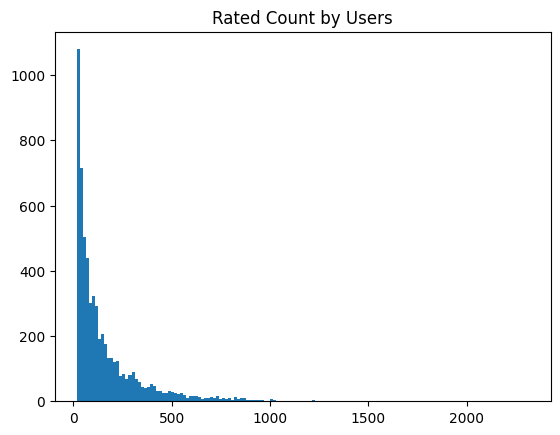

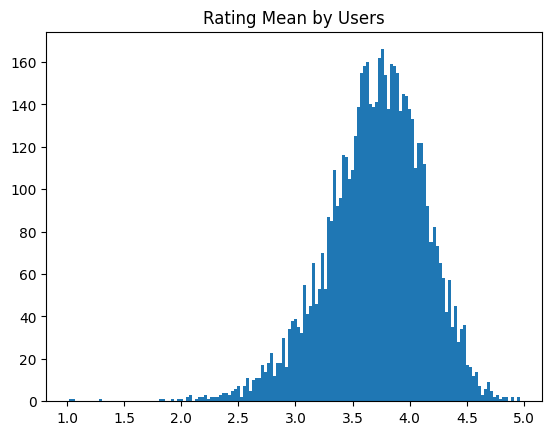

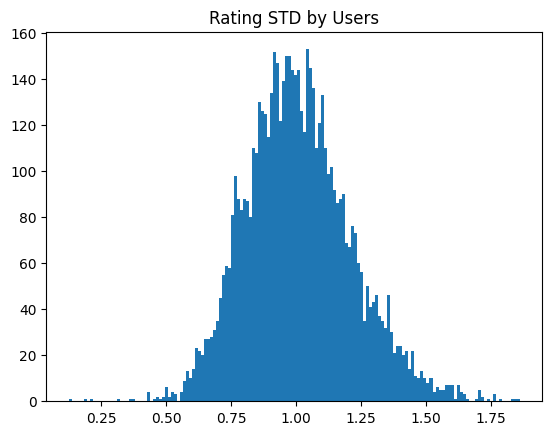

<Figure size 640x480 with 0 Axes>

In [3]:
# 유저별로 평가한 영화 개수('rated_count'), 평균 영화 점수('rating_mean'), 평가한 영화 점수의 편차('rating_std')
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(rated_count = 'count',
                                                                        rating_mean = 'mean',
                                                                        rating_std = 'std')

# 유저별로 평가한 영화 개수의 분포
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)
plt.title('Rated Count by Users')
plt.figure()

# 유저별로 평가한 평균 영화 점수의 분포
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)
plt.title('Rating Mean by Users')
plt.figure()
# 유저별로 평가한 영화 점수 편차의 분포
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)
plt.title('Rating STD by Users')
plt.figure()

plt.show()

실행 결과, 
영화 평가 횟수가 100회 미만인 사용자가 많고, 평점은 3.5~4.0점 사이에서 표준편차 10% 정도의 수치를 보인다.  

In [12]:
rating_data.head(3)

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [9]:
## user-movie 시각화 ##
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터 생성
rating_table = rating_data[['user_id', 'movie_id', 'rating']]
rating_table = rating_table.set_index(['user_id', 'movie_id'])
rating_table = rating_table.unstack() # 인덱스를 컬럼으로 보낸다.

rating_table.head(2)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[2 rows x 3706 columns]

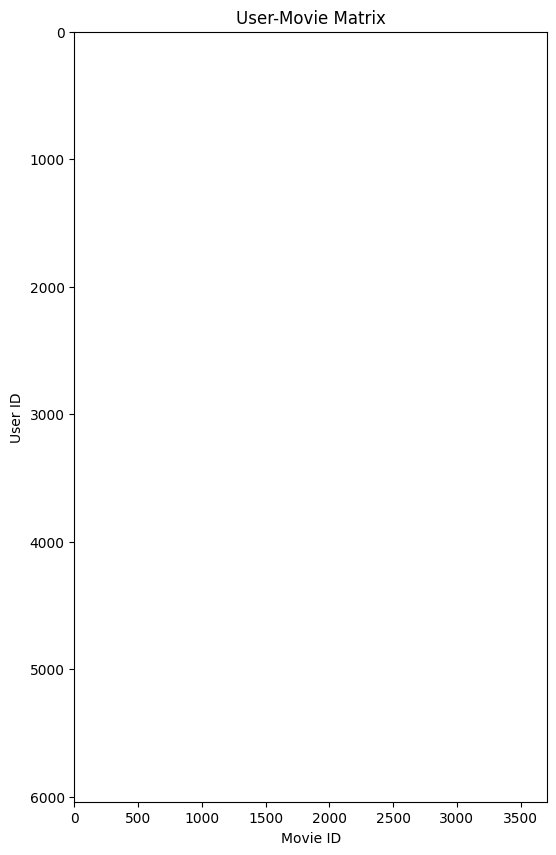

In [11]:
# user-movie 표(rating_table)를 그래프로 시각화
plt.figure(figsize=(10, 10))
plt.imshow(rating_table) # image show 
plt.grid(False)
plt.title('User-Movie Matrix') # 행렬
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()

아무것도.. 보이지 않지만 ㅎ ㅠ
색이 다른 수많은 점들이 찍혀있어야 한다.  

대부분의 흰색 점은 아직 매겨지지 않은 rating, 즉 예측해야할 값이며  (대부분이 비어있는 행렬 = 희소 행렬)  
1~5점 사이 점수들은 점수별로 다른 색상의 점으로 표현된다.  

비어있는 rating을 채워 넣을 수 있는 가장 대표적인 방법은  
행렬의 빈 공간을 채우는 **행렬 완성(Matrix Completion)** 기법이다.  

## 3.3 예측: 수학적 기법을 활용해 평점 예측하기

행렬 완성은 **행렬 분해(Matrix Factorization)** 방법을 이용한다.  
행렬 분해는 **하나의 행렬을 여러 개의 행렬 곱으로 나타내는 방법**이다.  

이번 예제에서는 행렬 분해 중에서 가장 활용도가 높은 **특이값 분해(Singular Value Decompostion, SVD)** 방법을 활용하여 rating을 예측해 보자.  
SVD란 (m,n) 행렬 A를 3개의 행렬(U, S, V)로 나누는 것을 의미한다.  
그리고 이를 반대로 이용하면 3개의 행렬로 원래의 (m,n) 행렬 A를 근사할 수 있다.  

행렬 완성의 과정  
a. 3개로 나눠진 행렬 U, S, V의 값을 임의의 숫자로 초기화한다.  
b. 임의의 값으로 채워진 3개의 행렬을 곱하여 새로운 행렬 A'을 계산한다.    
c. A'과 A를 비교한다.    
d. 비교값이 최대한 비슷해지는 b에서의 임의의 값을 학습한 뒤, 행렬 A'의 빈 공간을 채워 넣는다.   

**surprise 라이브러리를 사용하여 데이터에 SVD 적용하기**

In [82]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

## SVD 라이브러리를 학습하기 위한 학습 데이터 생성 ##
# 평점의 범위가 1~5인 Reader 객체 생성
reader = Reader(rating_scale=(1, 5)) 

# rating_data를 surprise 라이브러리의 데이터셋 형태로 변환
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델 학습
train_start = time.time()

model = SVD(n_factors=8,
           lr_all=0.005, # learning rate for all parameters
           reg_all=0.02, # regularization term for all parameters
           n_epochs=100)
model.fit(train_data)

train_end = time.time()

print('training time of model: %2f seconds' % (train_end - train_start))

training time of model: 8.025264 seconds


**영화 점수를 예측할 타겟 유저 선정하기**

In [16]:
# user_id가 4인 유저의 영화 평가 데이터
target_user_id = 4
target_user_data = rating_data[rating_data['user_id'] == target_user_id]
target_user_data.head(3)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282


In [18]:
# user_id: 4 유저가 평가한 영화 목록을 {movie_id : rating} 형태로 추출
target_user_movie_rating_dict = {}
for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']

print(target_user_movie_rating_dict)   

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


**타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 영화 Top 10 선정**

In [80]:
# 타겟 유저(user_id: 4)가 보지 않은 영화를 테스트 데이터로 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating)) # (4, n, 0)

# 타겟 유저의 평가 점수 예측
target_user_predictions = model.test(test_data)

In [32]:
target_user_predictions[:3]

[Prediction(uid=4, iid=1, r_ui=0, est=4.261504059673228, details={'was_impossible': False}),
 Prediction(uid=4, iid=2, r_ui=0, est=3.216421674251671, details={'was_impossible': False}),
 Prediction(uid=4, iid=3, r_ui=0, est=2.6064909723921503, details={'was_impossible': False})]

In [41]:
# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for userid, movieid, rating, predicted_rating, _ in predictions:
        if user_id == userid:
            if movieid not in user_history: # 평점을 매기지 않은 영화라면, 
                target_user_movie_predict_dict[movieid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions,
                                                           user_id=target_user_id,
                                                           user_history=target_user_movie_rating_dict)

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 평점 TOP 10 영화 선정
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     # items(): Key와 Value의 쌍을 튜플로 묶은 값을 dict_items 객체로 반환
                                    key=operator.itemgetter(1), 
                                     # operator.itemgetter(n): 아이템 튜플의 n번째 요소를 기준으로 정렬
                                    reverse=True)[:10] 
                                     # 상위 10개 (reverse=False: 하위)

target_user_top10_predicted

[(53, 5),
 (213, 5),
 (246, 5),
 (527, 5),
 (615, 5),
 (669, 5),
 (750, 5),
 (800, 5),
 (858, 5),
 (898, 5)]

In [42]:
# 타이틀을 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ':', predicted_rating)

Lamerica (1994) : 5
Burnt By the Sun (Utomlyonnye solntsem) (1994) : 5
Hoop Dreams (1994) : 5
Schindler's List (1993) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Aparajito (1956) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Lone Star (1996) : 5
Godfather, The (1972) : 5
Philadelphia Story, The (1940) : 5


## 3.4 평가: 예측 모델 평가하기

예측이 얼마나 정확한지는 모델이 행렬을 얼마나 정확하게 완성했는지를 살펴보며 평가할 수 있다.  
행렬 완성의 가장 보편적인 평가 방법은 **RMSE**를 계산하는 것이다.  

**RMSE**

In [84]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 학습 데이터 생성. 학습 데이터와 테스트 데이터를 8:2로 분할
reader = Reader(rating_scale=(1,5)) # 평점 범위가 1~5 사이인 Reader 객체 생성
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# SVD 모델 학습
train_start = time.time()

model = SVD(n_factors=8,
           lr_all=0.005,
           reg_all=0.02,
           n_epochs=100)
model.fit(train_data)

train_end = time.time()
print('training time of model: %.2f seconds' % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE
print('RMSE of test dataset in SVD model:')
accuracy.rmse(predictions)

training time of model: 12.68 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8623


0.8622660022581978

RMSE를 이용해 파라미터 n_factors의 적당한 값을 찾아보자.  

**하이퍼 파라미터 튜닝**

RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8837
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8752
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8669
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8651
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8599
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8601
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8608
RMSE of test dataset in SVD model, n_factors=8
RMSE: 0.8592
RMSE of test dataset in SVD model, n_factors=9
RMSE: 0.8612
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8632
RMSE of test dataset in SVD model, n_factors=11
RMSE: 0.8642
RMSE of test dataset in SVD model, n_factors=12
RMSE: 0.8670
RMSE of test dataset in SVD model, n_factors=13
RMSE: 0.8671
RMSE of test dataset in SVD model, n_factors=14
RMSE: 0.8704


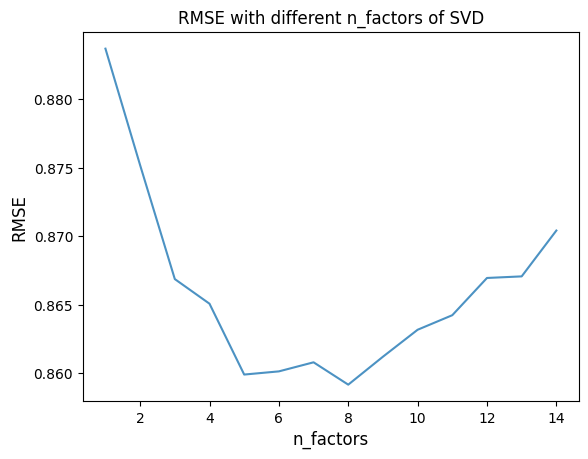

In [88]:
rmse_list = []
for n in range(1, 15):
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list.append(rmse_result)

plt.plot(range(1, 15), rmse_list, alpha=0.8)
plt.title('RMSE with different n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

1-15 사이의 파라미터 f_factors 중, **n_factors 값이 8일 때 가장 좋은 성능**을 보인다는 것을 알 수 있다.  

이번에는 4번 유저의 예측 평점과 실제 평점을 비교하는 시각화 그래프를 출력해보자.  
아래는 4번 유저가 영화를 아직 보지 않았다는 가정하에 실제로 보았던 21개 영화의 가상 예측 평점을 계산한 것이다.  

**예측 평점과 실제 평점 비교**

In [53]:
## 평점 예측 ##
# 타겟 유저가 본 영화와 평점 데이터를 테스트 데이터로 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

# 타겟 유저의 예측 평점
target_user_predictions = model.test(test_data) # (user_id, movie_id, rating, estimated rating)

# 타겟 유저의 영화별 예측 평점을 target_user_movie_predict_dict로 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history: # 평점을 매긴 영화라면
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)
target_user_movie_predict_dict

{260: 4.082978659032432,
 480: 3.626354803621835,
 1036: 4.124497375938411,
 1097: 4.276197885263841,
 1196: 3.7867629517733143,
 1198: 4.407560799358884,
 1201: 4.132536538445137,
 1210: 3.3140000729555217,
 1214: 4.278000230750465,
 1240: 4.101892447459017,
 1387: 4.540847856544061,
 1954: 4.179802596994238,
 2028: 4.4900434444721,
 2366: 4.049260214321556,
 2692: 3.788343445104327,
 2947: 4.069729036165915,
 2951: 4.006124591096515,
 3418: 4.084822932105716,
 3468: 4.525458928900468,
 3527: 3.2679698454140715,
 3702: 3.5240580875854066}

In [54]:
len(target_user_movie_predict_dict)

21

위 결과는 4번 유저가 실제로 관람했던 21개의 영화에 대한 예측 평점을 보여준다.  

아래는 예측 평점, 실제 평점, 영화 제목을 하나로 출력한 결과이다.   

In [57]:
# 예측 평점과 실제 평점을 영화 타이틀에 매핑
real_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1 
    predicted_rating = round(predicted_rating, 2)
    real_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print('movie', str(idx), ':', movie_title, '-', real_rating, '/', predicted_rating)
    
    real_rating_list.append(real_rating) # 나중에 시각화할 때 쓰기 위해 리스트로 저장
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(movie_title)

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.08
movie 2 : Jurassic Park (1993) - 4 / 3.63
movie 3 : Die Hard (1988) - 4 / 4.12
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.28
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.79
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.41
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.13
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.31
movie 9 : Alien (1979) - 4 / 4.28
movie 10 : Terminator, The (1984) - 5 / 4.1
movie 11 : Jaws (1975) - 5 / 4.54
movie 12 : Rocky (1976) - 5 / 4.18
movie 13 : Saving Private Ryan (1998) - 5 / 4.49
movie 14 : King Kong (1933) - 4 / 4.05
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 3.79
movie 16 : Goldfinger (1964) - 5 / 4.07
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.01
movie 18 : Thelma & Louise (1991) - 4 / 4.08
movie 19 : Hustler, The (1961) - 5 / 4.53
movie 20 : Predator (1987) - 1 / 3.27
movie 21 : Mad Max (1979) - 4 / 3.52


**예측 평점과 실제 평점 시각화**

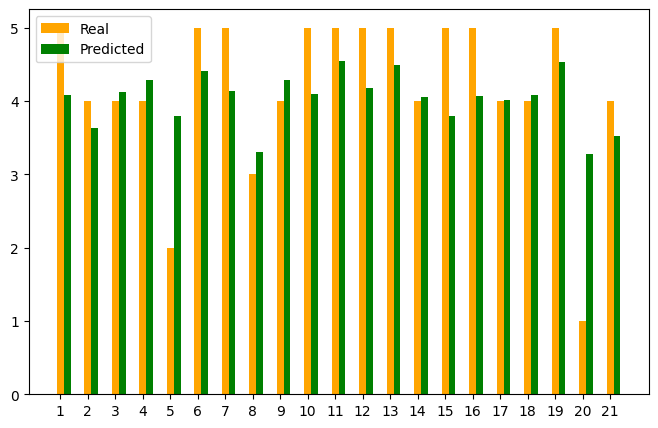

In [79]:
## 예측 평점과 실제 평점 비교 시각화 ##
# 예측 평점과 실제 평점을 리스트로 추출
real = real_rating_list
predicted = predicted_rating_list

# 영화의 개수만큼 막대 그래프의 index 개수 생성
plt.figure(figsize=(8, 5))
index = np.arange(len(movie_title_list)) # array([0, 1, 2, ..., 20]) # 21개
bar_width = 0.25

# 실제 점수와 예측 점수를 bar 그래프로 출력
rects1 = plt.bar(index, real, bar_width, color='orange', label='Real')
rects2 = plt.bar(index+bar_width, predicted, bar_width, color='green', label='Predicted')
        # plt.bar(x coordinates of the bars, height, width, color, label)
idx = index + 1
plt.xticks(index, idx)
plt.legend()
plt.show()

위 그래프는 예측 평점과 실제 평점을 시각화한 것이다.  
약 1~2개 정도의 영화를 제외하면 실제 평점과 예측 평점이 크게 다르지 않은 것을 알 수 있다.  

## 정리

- **행렬 완성**
    - 행렬의 빈 공간을 완성하여 평점을 예측한다.
    - User-Item-Rating 데이터셋은 행렬로 나타낼 수 있으며, 행렬의 Rating을 예측하는 것이 행렬 완성의 목적이다.  
- **행렬 분해**
    - 행렬 분해를 역이용하여 행렬을 완성할 수 있다. 그중, SVD라는 방법이 널리 사용된다.  
- **예상 평점의 정확도**
    - 행렬의 예측 요소(Rating)을 RMSE로 평가한다.  
    - 기존 Rating에 존재하는 값들과 SVD로 생성된 행렬에서 예측된 값들을 비교하여 RMSE를 계산할 수 있다.   